## Analysis with "DumbTo" Stimulus

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers

import numpy as np

In [2]:
sub_DumbTo = pd.read_csv("./Data/Subsamples/DumbTo.csv")
print("Subject Count: ",len(sub_DumbTo.Subject_ID.unique()))
print("Columns:\n")
print(sub_DumbTo.columns)

Subject Count:  45
Columns:

Index(['Study', 'Subject_ID', 'StimName', 'Experiment_Time',
       'CALIB_VALID_POINTS', 'Group', 'Age', 'Handedness', 'Country',
       'Language', 'Gender', 'Eyewear', 'Session_Date', 'Block',
       'Big5_Openness', 'Big5_Conscientiousness', 'Big5_Extraversion',
       'Big5_Agreeableness', 'Big5_Neuroticism', 'Expert', 'Ethnicity',
       'SessionDate', 'OrderStim', 'StartTime', 'EndTime', 'PosNegAdSAM',
       'ExciteCalmAdSAM', 'ImpCom', 'PosCom', 'LikeCom', 'ViewsCom',
       'PreLikelyFav', 'PostLikelyFav', 'LikelyFavDifference', 'PostOften',
       'CNT', 'Eye_Time', 'TIME_TICK', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD',
       'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'LPCX', 'LPCY', 'LPD',
       'LPS', 'LPV', 'RPCX', 'RPCY', 'RPD', 'RPS', 'RPV', 'LPUPILD', 'LPUPILV',
       'RPUPILD', 'RPUPILV', 'Frame', 'Distance_to_Next_Frame', 'Face_Time',
       'Anger_Evidence', 'Anger_Intensity', 'Contempt_Evidence',
       'Contempt_Intensity', 'Disgust_Ev

In [3]:
related_features = ['FPOGX', 'FPOGY', 'FPOGS', 'FPOGD',
       'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'LPCX', 'LPCY', 'LPD',
       'LPS', 'LPV', 'RPCX', 'RPCY', 'RPD', 'RPS', 'RPV', 'LPUPILD', 'LPUPILV',
       'RPUPILD', 'RPUPILV', 'Face_Time',
       'Anger_Evidence', 'Anger_Intensity', 'Contempt_Evidence',
       'Contempt_Intensity', 'Disgust_Evidence', 'Disgust_Intensity',
       'Joy_Evidence', 'Joy_Intensity', 'Fear_Evidence', 'Fear_Intensity',
       'Negative_Evidence', 'Negative_Intensity', 'Neutral_Evidence',
       'Neutral_Intensity', 'Positive_Evidence', 'Positive_Intensity',
       'Sadness_Evidence', 'Sadness_Intensity', 'Surprise_Evidence',
       'Surprise_Intensity', 'Heart_Time',
       'Normed_Heart_Rate',
       'Normed_LPD', 'Normed_RPD', 'bpogx_dmean', 'bpogy_dmean',
       'combined_normed_bpogxy', 'Normed_LPS', 'Normed_RPS']

In [4]:
data_recall = pd.read_csv('./Data/Lab_Recall_Hand_Edited/SuperMovie1516_L.csv')

In [5]:
data_recall.DumbTo.describe()

count    63.000000
mean      6.285714
std       1.660048
min       1.000000
25%       7.000000
50%       7.000000
75%       7.000000
max       7.000000
Name: DumbTo, dtype: float64

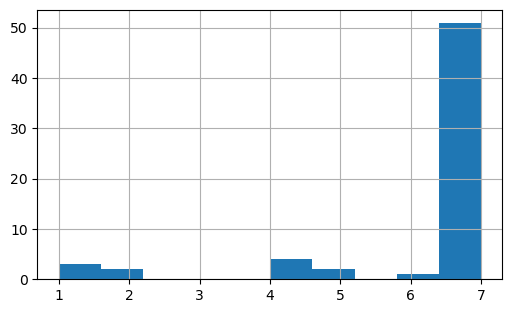

In [6]:
data_recall.DumbTo.hist(figsize=(6,3.5))
plt.show()

In [7]:
seq_length = sub_DumbTo.groupby("Subject_ID").size().reset_index()
seq_length.columns = ["Subject_ID", "Length"]
num_of_subjects = seq_length.shape[0]
print(num_of_subjects)

45


In [8]:
seq_length.Length.min()

9676

In [9]:
# remove user 344 from seq-length and data (length is outlier)
seq_length = seq_length[seq_length.Subject_ID != 344]
sub_DumbTo = sub_DumbTo[sub_DumbTo.Subject_ID != 344]

In [10]:
seq_length.Length.min()

9744

In [11]:
seq_length['Sum_Length'] = seq_length.Length.cumsum() 

In [12]:
seq_length = seq_length.reset_index()

In [13]:
seq_length.shape

(44, 4)

In [14]:
9744*44

428736

In [15]:
sub_DumbTo.shape

(428964, 98)

In [16]:
cut_off = 5000

rem_index = np.zeros(sub_DumbTo.shape[0])
rem_index[0 : cut_off] = 1  
for i in range(0, seq_length.shape[0]-1):
    rem_index[seq_length.Sum_Length[i] : seq_length.Sum_Length[i]  + cut_off] = 1
    
sub_DumbTo["Rem_Index"] = rem_index

In [17]:
sub_DumbTo = sub_DumbTo[sub_DumbTo.Rem_Index == 1]

In [18]:
sub_DumbTo = sub_DumbTo[related_features]

In [19]:
sub_DumbTo.shape

(220000, 53)

In [20]:
x = sub_DumbTo.to_numpy()
x = x.reshape(seq_length.shape[0], -1, len(related_features))

In [21]:
x.shape

(44, 5000, 53)

In [22]:
y = []
for subject_id in seq_length.Subject_ID:
    y.append(data_recall[data_recall.ExternalReference == subject_id].DumbTo.tolist()[0])

In [23]:
y = np.array(y)

## Modeling

In [24]:
x_train = x[:36]
y_train = y[:36]
x_valid = x[37:]
y_valid = y[37:]

In [25]:
special_value = -9999.99
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = cut_off, padding = "post", dtype = 'float64', value = special_value)
x_valid = keras.preprocessing.sequence.pad_sequences(x_valid, maxlen = cut_off, padding = "post", dtype = 'float64', value = special_value)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(36, 5000, 53)
(36,)
(7, 5000, 53)
(7,)


In [26]:
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(cut_off, x.shape[2])))
model.add(keras.layers.LSTM(32,))
model.add(keras.layers.Dense(1,))

In [27]:
model.compile(loss = keras.losses.MeanSquaredError(),
              optimizer = keras.optimizers.Adam(learning_rate=0.01))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5000, 53)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                11008     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 11,041
Trainable params: 11,041
Non-trainable params: 0
_________________________________________________________________


In [29]:
print(x_train.shape)
print(y_train.shape)

(36, 5000, 53)
(36,)


In [30]:
x_train3 = np.nan_to_num(x_train)
x_valid3 = np.nan_to_num(x_valid)

In [31]:
np.isnan(x_train3).any()

False

In [32]:
print(x_train3.shape)
print(x_valid3.shape)

(36, 5000, 53)
(7, 5000, 53)


In [33]:
history = model.fit(x = x_train3, y = y_train,
                    validation_data = (x_valid3, y_valid),
                    epochs = 100)

Epoch 1/100
2/2 [==============================] - 3s 1s/step - loss: 42.0401 - val_loss: 31.7806
Epoch 2/100
2/2 [==============================] - 2s 807ms/step - loss: 36.9153 - val_loss: 29.7662
Epoch 3/100
2/2 [==============================] - 2s 822ms/step - loss: 34.2554 - val_loss: 28.3639
Epoch 4/100
2/2 [==============================] - 2s 818ms/step - loss: 32.4870 - val_loss: 26.9989
Epoch 5/100
2/2 [==============================] - 2s 879ms/step - loss: 30.9441 - val_loss: 25.6743
Epoch 6/100
2/2 [==============================] - 2s 827ms/step - loss: 29.4614 - val_loss: 24.3995
Epoch 7/100
2/2 [==============================] - 2s 834ms/step - loss: 28.0117 - val_loss: 23.1801
Epoch 8/100
2/2 [==============================] - 2s 823ms/step - loss: 26.6015 - val_loss: 22.0052
Epoch 9/100
2/2 [==============================] - 2s 821ms/step - loss: 25.2550 - val_loss: 20.8670
Epoch 10/100
2/2 [==============================] - 2s 835ms/step - loss: 23.9462 - val_loss: 

2/2 [==============================] - 2s 1s/step - loss: 1.1313 - val_loss: 3.6684
Epoch 84/100
2/2 [==============================] - 2s 1s/step - loss: 1.1296 - val_loss: 3.6756
Epoch 85/100
2/2 [==============================] - 2s 1s/step - loss: 1.1285 - val_loss: 3.6815
Epoch 86/100
2/2 [==============================] - 2s 1s/step - loss: 1.1269 - val_loss: 3.6838
Epoch 87/100
2/2 [==============================] - 2s 1s/step - loss: 1.1258 - val_loss: 3.6851
Epoch 88/100
2/2 [==============================] - 2s 1s/step - loss: 1.1252 - val_loss: 3.6879
Epoch 89/100
2/2 [==============================] - 2s 1s/step - loss: 1.1243 - val_loss: 3.6921
Epoch 90/100
2/2 [==============================] - 2s 1s/step - loss: 1.1237 - val_loss: 3.6963
Epoch 91/100
2/2 [==============================] - 2s 1s/step - loss: 1.1224 - val_loss: 3.7002
Epoch 92/100
2/2 [==============================] - 2s 1s/step - loss: 1.1216 - val_loss: 3.7056
Epoch 93/100
2/2 [=========================